{download}`Download this notebook <2_kuramoto.ipynb>`

## Optimally synchronizable Kuramoto networks

> **`gradnet` concepts demonstrated below**
> - **ODE integration** via `gradnet.integrate_ode`
> - Custom **loss function** for a dynamical system
> - Optimizer selection
> - Logging using TensorBoard


### Problem setup
Consider the Kuramoto model for nodes with internal frequencies $\{\omega_i\}_{i=1}^N$ with weighted adjacency matrix $A_{ij}$ obaying the dynamics:
$$
\frac{d\theta_i}{dt} = \omega_i + \sum_{j=1}^N A_{ij} \sin(\theta_j - \theta_i)
$$

Notice, that the adjacency matrix here is weighted: $A_{ij}=0$ if there is no edge between nodes $i$ and $j$, otherwise $A_{ij}$ is the edge-weight of the existing edge.

For this model, we seek the optimal network, with the fixed total edge-weight budget which supports the strongest synchronization. 

Synchronization in Kuramoto model is measured as:
$$
r(t) = \left| \frac{1}{N} \sum_{j=1}^N e^{i\theta_j(t)} \right|
$$
where $r(t) \in [0, 1]$ measures the degree of phase synchronization at time $t$. This is implemented in the function `loss_fn`.

### Vectorizing the ODE (Optional)
We can simplify the right-hand-side of the ODE by applying the trig identity $\sin(a-b) = \cos(a)\sin(b) - \sin(a)\cos(b)$, which allows efficient vectorized computation of the interaction term. The resulting vectorized ODE is:
$$
\frac{d\boldsymbol{\theta}}{dt} = \boldsymbol{\omega} + \left[ \cos(\boldsymbol{\theta}) \odot (A\cdot \sin(\boldsymbol{\theta})) - \sin(\boldsymbol{\theta}) \odot (A\cdot \cos(\boldsymbol{\theta})) \right]
$$
where $\odot$ denotes the Hadamard (element-wise) product. This is implemented in the function `dθ_dt` in the code

Note: vectorization is not required, but it helps accelerate the computations (especially if using a GPU).

### GradNet optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/1000 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 1.0 M  | train
-----------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.000     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1000` reached.


optimal synchrony: 0.9986288547515869


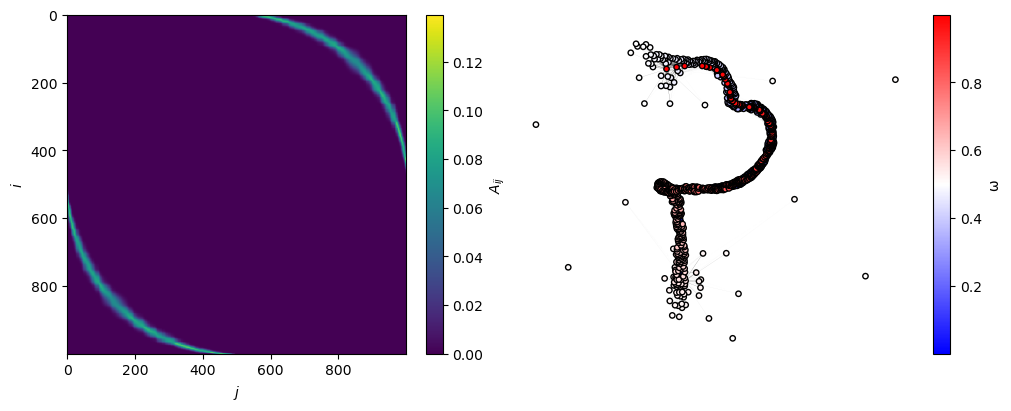

In [1]:
from gradnet import GradNet, ode, trainer
import numpy as np
import torch
from gradnet.utils import plot_adjacency_heatmap, plot_graph
import matplotlib.pyplot as plt
from matplotlib.cm import bwr


# set up problem parameters preferably in Torch
N = 1000
budget_per_node = 2.0
ω = np.sort(np.random.random(N))  # uniformly distributed natural frequencies in [0, 1]
ω = torch.tensor(ω)  # convert to torch tensor

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=False, 
             delta_sign="nonnegative", final_sign="free", use_budget_up=True)  # create the GradNet instance

def dθ_dt(t, θ, A, ω):
    # Kuramoto model: dθ_i/dt = ω_i + Σ A_ij sin(θ_j - θ_i)
    sinx = torch.sin(θ)
    cosx = torch.cos(θ)
    return ω + cosx * (A @ sinx) - sinx * (A @ cosx)

def loss_fn(gn):
    tt = torch.linspace(0, 5, 150)  # time grid to evaluate the numerical solutions
    θ0 = torch.zeros(N)  # set the initial phases to 0 (this choice accelerates traning)

    f_params = {"ω": ω}  # contains every parameter of the dθ_dt beyond t, θ, and A. 
    tt, θθ = ode.integrate_ode(gn, f=dθ_dt, x0=θ0, tt=tt, f_kwargs=f_params)  # integrate the ODE

    rr = torch.abs(torch.mean(torch.exp(1j * θθ), dim=1)) # compute the synchronization time series
    r_mean = torch.mean(rr)  # average it over time

    return 1 - r_mean, {'r':r_mean}  # loss function is minimized, so in order to maximize synch, 


trainer.fit(gn=gn, 
            loss_fn=loss_fn, 
            num_updates=1000, 
            optim_cls=torch.optim.Adam, optim_kwargs={"lr": 1, "betas": (0.9, 0.999)}, 
            accelerator="cpu",
            logger=True);

loss, measures = loss_fn(gn)
print(f"optimal synchrony: {measures['r']}")

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plot_adjacency_heatmap(gn, ax=ax0)
plot_graph(gn, ax=ax1, draw_kwargs={'node_color': ω, 'cmap': bwr}, colorbar_label="ω")

On the left, the optimized adjacency matrix is plotted as a heatmap.

On the right, we show the sppring layout plot of the resulting weighted network. The edgeweights are repreented as the edge widths, and the node colors correspond to their intrinsic frequencies.